In [1]:
#!pip install pandas

In [2]:
import os
import pandas as pd
#!pip install openpyxl
#!pip install xlrd # to be able to read the xls file

# Install pygam if not already installed
try:
    import pygam
except ModuleNotFoundError:
    !pip install pygam

In [3]:
from pygam import LinearGAM, s
import numpy as np
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [4]:
# Define the data
years = np.arange(1997, 2025)
cases = np.array([18, 0, 0, 0, 0, 0, 6, 45, 100, 113, 88, 44, 74, 48, 62, 32, 39, 52, 145, 10, 4, 0, 1, 1, 1, 7, 12, 24])
deaths = np.array([0, 0, 0, 0, 0, 0, 4, 32, 43, 79, 59, 33, 32, 24, 34, 20, 25, 22, 42, 3, 2, 0, 1, 0, 1, 1, 4, 2])

# OR Create the DataFrame
data = pd.DataFrame({
    'Year': years,
    'Cases': cases,
    'Deaths': deaths
})

In [5]:
#!pip install openpyxl
#!pip install xlrd

In [6]:
file_name = 'H5N1_Cases_Death_Data.xls'  # Replace with your Excel file name
sheet_name = 'case_death_date' 
data1 = pd.read_excel(file_name, sheet_name=sheet_name)
data1['Cumulative_Cases'] = data1['Cases'].cumsum()
print(data1.head())

   Year  Cases  Deaths  Cumulative_Cases
0  1997     18       0                18
1  1998      0       0                18
2  1999      0       0                18
3  2000      0       0                18
4  2001      0       0                18


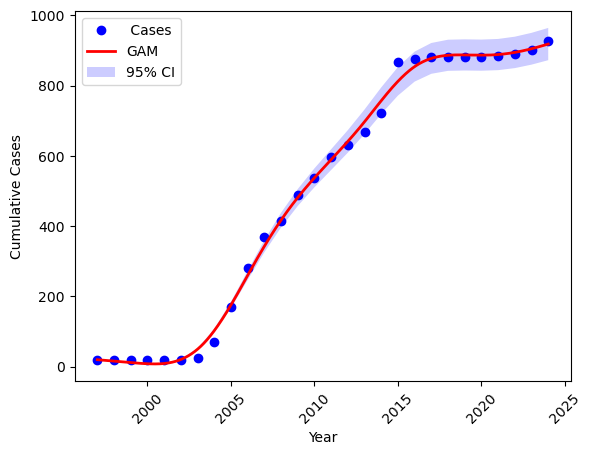

In [7]:
from scipy.interpolate import interp1d
data['Cumulative_Cases'] = data['Cases'].cumsum()

# Fit the GAM model
gam_model = LinearGAM(s(0)).fit(data['Year'].values.reshape(-1, 1), data['Cumulative_Cases'])

# Generate predictions for smooth curve
predicted_years = np.linspace(data['Year'].min(), data['Year'].max(), 10000)
predicted_cases = gam_model.predict(predicted_years.reshape(-1, 1))

# Plot the original data points
#plt.scatter(data['Year'], data['Cumulative_Cases'], color ='blue', label='Cases', alpha=0.5)
plt.plot(data['Year'], data['Cumulative_Cases'], 'bo', label=" Cases")
# Add the  smooth curve
plt.plot(predicted_years, predicted_cases, 'r-', linewidth=2, label='GAM')

# Add confidence interval shading using predicted_cases
# Interpolate predicted_cases to match the original data years
interp_function = interp1d(predicted_years, predicted_cases, kind='linear', fill_value="extrapolate")
predicted_cases_at_data_years = interp_function(data['Year'])

# Compute confidence intervals based on interpolated predicted cases
ci_lower = 0.95 * predicted_cases_at_data_years
ci_upper = 1.05 * predicted_cases_at_data_years


# Plot the confidence interval shading
plt.fill_between(
    data['Year'],
    ci_upper,
    ci_lower,
    color=(0, 0, 1, 0.2), 
    label='95% CI',# Semi-transparent blue
    edgecolor=None         # No border
)
# Add legend
plt.xlabel("Year")
plt.ylabel("Cumulative Cases")
#plt.title("Cumulative Cases: Observed vs Simulated")

plt.legend(loc='upper left')
plt.xticks(rotation=45)
# Show the plot
#plt.savefig('GAMplot.png', dpi=300, bbox_inches='tight')  # Save heatmap
plt.show()

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Define the human SVEIRD model
def human_modell(t, y, params):
    Sh, Vh, Eh, Ih, Rh, Dh, Sd, Vd, Ed, Id, Rd, Sw, Iw = y
    (
        theta_h, omega_h, mu_h, alpha_h, alpha_hd, alpha_hw, tau_h, sigma_h, delta_h, psi_h, gamma_h,
        theta_d, omega_d, mu_d, alpha_d, alpha_dw, tau_d, sigma_d, c_E, c_I, psi_d, gamma_d,
        theta_w, mu_w, alpha_w
    ) = params 
    Nh = Sh + Vh + Eh + Ih + Rh + Dh
    Nd = Sd + Vd + Ed + Id + Rd
    Nw = Sw + Iw
    phi1 = ((alpha_h * Ih) + (alpha_hd * Id) + (alpha_hw * Iw)) / Nh
    phi2 = ((alpha_d * Id) + (alpha_dw * Iw)) / Nd  # Force of infection
    phi3 = alpha_w / Nw
    
    dSh_dt = theta_h - (omega_h + mu_h + phi1) * Sh + psi_h * Vh
    dVh_dt = omega_h * Sh - (1 - gamma_h) * phi1 * Vh - mu_h * Vh - psi_h * Vh
    dEh_dt = phi1 * Sh + (1 - gamma_h) * phi1 * Vh - (tau_h + mu_h) * Eh
    dIh_dt = tau_h * Eh - (sigma_h + mu_h + delta_h) * Ih
    dRh_dt = sigma_h * Ih - mu_h * Rh
    dDh_dt = delta_h * Ih
    dSd_dt = theta_d - (omega_d + mu_d + phi2) * Sd + psi_d * Vd
    dVd_dt = omega_d * Sd - (1 - gamma_d) * phi2 * Vd - mu_d * Vd - psi_d * Vd
    dEd_dt = phi2 * Sd + (1 - gamma_d) * phi2 * Vd - (tau_d + mu_d + c_E) * Ed
    dId_dt = tau_d * Ed - (sigma_d + mu_d + c_I) * Id
    dRd_dt = sigma_d * Id - mu_d * Rd
    dSw_dt = theta_w - phi3 * Sw - mu_w * Sw
    dIw_dt = phi3 * Sw - mu_w * Iw
    return [
        dSh_dt, dVh_dt, dEh_dt, dIh_dt, dRh_dt, dDh_dt,
        dSd_dt, dVd_dt, dEd_dt, dId_dt, dRd_dt,
        dSw_dt, dIw_dt
    ]

# Objective function (least squares error)
def objective_function(params, t_data, cases_data, deaths_data):
    solution = solve_ivp(human_modell, [t_data[0], t_data[-1]], y0, t_eval=t_data, args=(params,))
    Ih_model = solution.y[3]  # Infected population
    Dh_model = solution.y[5]  # Dead population
    
    # Compute the error
    error_cases = np.sum((np.cumsum(Ih_model) - cases_data)**2)
    error_deaths = np.sum((np.cumsum(Dh_model) - deaths_data)**2)
    return error_cases + error_deaths

cumulative_cases = np.cumsum(cases)
cumulative_deaths = np.cumsum(deaths)

# Initial conditions
y0 = [1e4, 0, 0, cases[0], 0, deaths[0], 1e4, 0, 0, 0.1, 0, 0.5, 0]  # Example initial conditions
#y0 = [6e9, 0, 0, cases[0], 0, deaths[0], 1e12, 0, 0, 0.1, 0, 5e11, 0]  # Example initial conditions

# Initial parameter guesses
initial_params = [0.096, 0.9,0.5, 0.7, 0.152, 0.300, 0.858, 0.0159, 0.53, 0.0001, 0.0475, 0.1, 0.1,  0.01, 0.1, 0.2, 0.1, 0.05, 0.01, 0.8,0.01, 0.1, 0.2, 0.1, 0.05]

# Define parameter bounds (ensuring values are within [0,1])
bounds = [(0, 1)] * len(initial_params)

# Optimize parameters
result = minimize(objective_function, initial_params, args=(years, cumulative_cases, cumulative_deaths), bounds=bounds)
estimated_params = result.x

In [9]:
#print("Estimated Parameters:", estimated_params)
#theta_h, omega_h, mu_h, alpha_h, alpha_hd, alpha_hw, tau_h, sigma_h, delta_h, psi_h, gamma_h,
#theta_d, omega_d, mu_d, alpha_d, alpha_dw, tau_d, sigma_d, c_E, c_I, psi_d, gamma_d,
#theta_w, mu_w, alpha_w

In [10]:
# Plot cumulative cases
solution = solve_ivp(human_modell, [years[0], years[-1]], y0, t_eval=years, args=(estimated_params,))
Sh, Vh, Eh, Ih, Rh, Dh, Sd, Vd, Ed, Id, Rd, Sw, Iw = solution.y

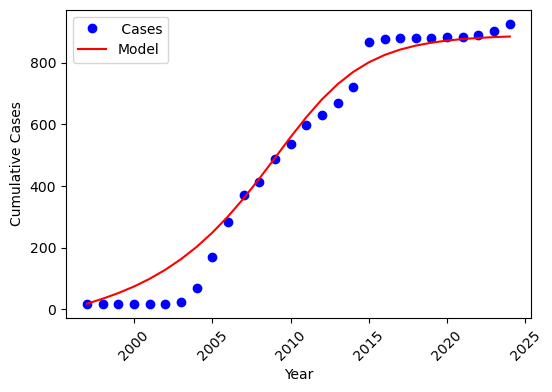

In [11]:

plt.figure(figsize=(6, 4))
plt.plot(years, cumulative_cases, 'bo', label=" Cases")
plt.plot(years, np.cumsum(Ih), 'r-', label="Model")
plt.xlabel("Year")
plt.ylabel("Cumulative Cases")
plt.xticks(rotation=45)
#plt.title("Cumulative Cases: Observed vs Simulated")
plt.legend()
#plt.savefig('modelFitPlot.png', dpi=300, bbox_inches='tight')  
plt.show()